# Naive Radical Polymerization Model

## Theory

Radical polymerization is a type of chain-growth polymerization in which the active center is a radical. The reaction mechanism typically involves three key steps: initiation, propagation, and termination. For a system where radical termination occurs solely by combination, the transient species balances are:

\begin{align*}
\frac{\textrm{d}[I]}{\textrm{d}t} & = - k_d [I] \\
\frac{\textrm{d}[M]}{\textrm{d}t} & = - k_p [M] \sum_{i}[R^{\cdot}_{i}] - 2 f k_d [I] \\
\frac{\textrm{d}[R^{\cdot}_{n}]}{\textrm{d}t} & = k_p[M]\left([R^{\cdot}_{n-1}]-[R^{\cdot}_{n}]\right)- 2 k_{tc} [R^{\cdot}_{n}] \sum_{i}[R^{\cdot}_{i}] + \delta_{n,1}2fk_d[I] \\
\frac{\textrm{d}[D_n]}{\textrm{d}t} & = k_{tc} \sum_{i=1}^{n-1}[R^{\cdot}_{n-i}][R^{\cdot}_{i}]
\end{align*}

By defining an appropriate upper limit for the chain length $N$, we obtain a closed system of $2N+2$ ordinary differential equations (ODEs). However, numerically solving this ODE system is challenging. Under typical polymerization conditions, very long chains are formed, requiring rather large $N$ values (possibly $10^4$-$10^5$ or higher). Moreover, the presence of short-lived radical species makes the ODE system stiff, requiring implicit solvers.

Special numerical methods are therefore needed to solve the population balances efficiently and stably. You can read about it [here](https://onlinelibrary.wiley.com/doi/abs/10.1002/mren.202000010). In this tutorial, we integrate the discrete population balances directly. This brute-force approach is quite inefficient (be prepared to wait 20-60 s, depending on CPU performance), but it serves a pedagogical purpose by providing transparency in its workings.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from numba import njit
from scipy.integrate import solve_ivp

## Numerical solution

### Input parameters

In [2]:
# Parameters
kp = 2e3  # L/(mol.s)
kt = 1e8  # L/(mol.s)
kd = 1e-4  # 1/s
f = 0.5

# Initial concentrations
M0 = 1.  # mol/L
I0 = 1e-2  # mol/L

# Simulation time
tend = 3600  # s

# Maximum chain length
N = 1000

### Check $N$ vs kinetic chain length 

In [3]:
# Initial kinetic chain length, to get an idea of DPn
# `N` must be well above this value, otherwise chains escape the numerical domain
kinetic_chain_length = kp/(2*np.sqrt(f*kd*kt)) * M0/np.sqrt(I0)
if (N < 5*kinetic_chain_length):
    print(f"The kinetic chain length is {kinetic_chain_length:.0f}.")
    print(f"N={N} appears insufficient.")

### Population balance equations

In [4]:
@njit()
def initiation(I: float,
               M: float,
               k: float,
               f: float
               ) -> tuple[float, float, float]:
    """I -> 2 I*
       I* + M -> R1

    d[I]/dt = -k*[I]
    d[M]/dt = -2*f*k*[I]
    d[R1]/dt = 2*f*k*[I]
    """
    Idot = -k*I
    ri = 2*f*k*I*(M/(M + 1e-9))
    Mdot = -ri
    R1dot = ri
    return Idot, Mdot, R1dot


@njit()
def propagation(R: np.ndarray,
                M: float,
                k: float
                ) -> tuple[float, np.ndarray]:
    """R(n) + M -> R(n+1)

    d[Rn]/dt = k*[M]*([Rn-1] - [Rn])
    d[M]/dt = -k*[M]*sum([Rn])
    """

    Mdot = -k*M*R.sum()
    Rdot = np.zeros_like(R)
    Rdot[1:] = R[:-1]
    Rdot -= R
    Rdot *= k*M
    return Mdot, Rdot


@njit()
def combination(P: np.ndarray,
                k: float
                ) -> tuple[float, np.ndarray]:
    """P(n) + P(m) -> D(n+m)

    d[Pn]/dt = -2*k*[Pn]*[P]
    d[Dn]/dt = k * sum i=1:n-1 [Pn-i]*[P_i]
    """
    # d[Pn]/dt
    Pdot = -2*k*P*P.sum()
    # d[Dn]/dt
    Ddot = np.zeros_like(P)
    for n in range(2, P.size):
        accum = 0.
        for i in range(1, n):
            accum += P[i]*P[n-i]
        Ddot[n] = accum
    Ddot *= k
    return Pdot, Ddot


@njit()
def calc_ydot(t: float,
              y: np.ndarray,
              kd: float,
              kp: float,
              kt: float,
              f: float,
              state_vector_sections: tuple
              ) -> np.ndarray:
    """Derivative of the state vector, dy/dt."""
    # Unpack the state vector
    I, M, R, D = np.split(y, state_vector_sections)
    I = I[0]
    M = M[0]
    # Compute kinetic steps
    Idot, Mdot, R1dot = initiation(I, M, kd, f)
    Mdot_, Rdot = propagation(R, M, kp)
    Mdot += Mdot_
    Rdot_, Ddot = combination(R, kt)
    Rdot += Rdot_
    Rdot[1] += R1dot
    # Assemble derivative state vector
    return np.concatenate((np.array([Idot]), np.array([Mdot]), Rdot, Ddot))

### ODE Solution

In [5]:
# Chain lengths
x = np.arange(0, N+1)

# Initialize distributions
R0 = np.zeros_like(x)
D0 = np.zeros_like(x)

# State vector sections
state_vector_sections = (1, 2, 2+N+1)

# Integration
teval = np.linspace(0, tend, 100)
y0 = np.concatenate(([I0], [M0], R0, D0))
atol = np.concatenate(
    ([1e-6], [1e-6], 1e-11*np.ones_like(R0), 1e-7*np.ones_like(D0)))
solution = solve_ivp(calc_ydot,
                     t_span=(0, tend),
                     y0=y0,
                     t_eval=teval,
                     args=(kd, kp, kt, f, state_vector_sections),
                     method='LSODA',  # implicit solver is a MUST
                     rtol=1e-3,
                     atol=atol
                     )

# Unpack results
t = solution.t
y = np.split(solution.y, state_vector_sections)

### Plots

#### Scalar species

Text(0.5, 0, 'time [s]')

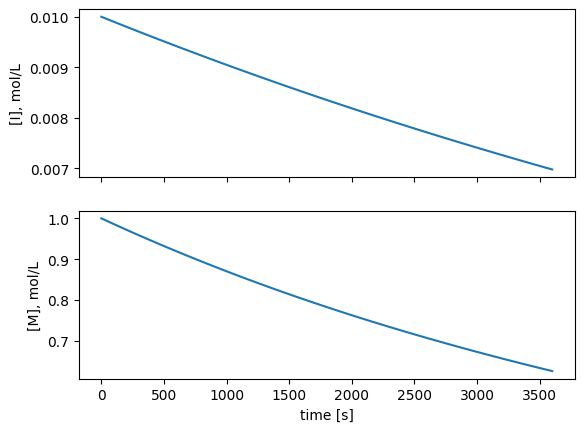

In [6]:
fig1, ax = plt.subplots(2, 1, sharex=True)
# [I] and [M]
for i in range(0, 2):
    ax[i].plot(t, y[i][0,:])
ax[0].set_ylabel("[I], mol/L")
ax[1].set_ylabel("[M], mol/L")
ax[-1].set_xlabel("time [s]")

#### Moments

In [7]:
def moment(P: np.ndarray, k: int):
    "k-th moment of P"
    return np.dot(x**k, P)

Mass balance error: 5.1e-03


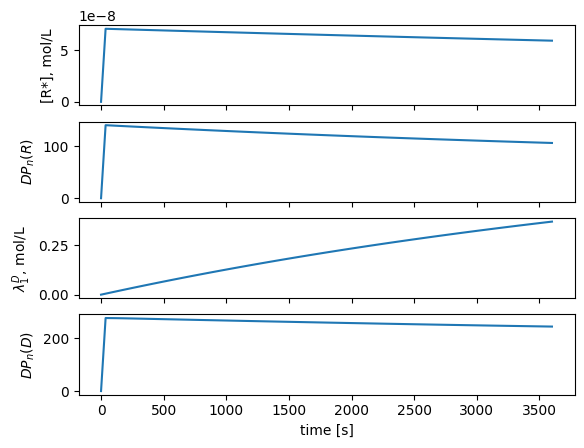

In [8]:
fig2, ax = plt.subplots(4, 1, sharex=True)
eps = np.finfo(float).eps
# 0-th moment of R*
m0_R = moment(y[2], 0)
ax[0].plot(t, m0_R)
ax[0].set_ylabel("[R*], mol/L")
# DPn R*
m1_R = moment(y[2], 1)
ax[1].plot(t, m1_R/(m0_R + eps))
ax[1].set_ylabel(r"$DP_n(R)$")
# 1st-moment of D*
m1_D = moment(y[3], 1)
ax[2].plot(t, m1_D)
ax[2].set_ylabel(r"$\lambda_1^D$" ", mol/L")
# DPn
m0_D = moment(y[3], 0)
ax[3].plot(t, m1_D/(m0_D + eps))
ax[3].set_ylabel(r"$DP_n(D)$")
ax[-1].set_xlabel("time [s]")

mass_balance_error = np.max(np.abs((m1_D + y[1][0, :])/M0 - 1.0))
print(f"Mass balance error: {mass_balance_error:.1e}")

#### Chain-length distribution

Text(0.5, 0, 'Chain length')

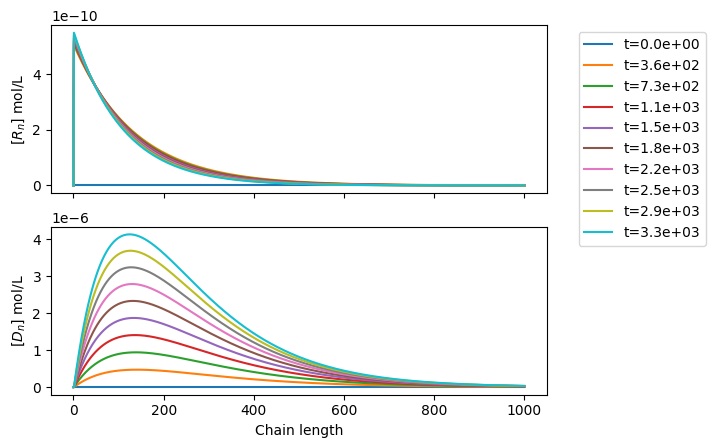

In [9]:
fig3, ax = plt.subplots(2, 1, sharex=True)
for i in range(0, 2):
    for ii in range(0, len(t), round(len(t)/10)):
        label = f"t={t[ii]:.1e}"
        ax[i].plot(x, y[2+i][:, ii], label=label)  # x*P[:,i]
ax[0].set_ylabel(r"$[R_n]$" + " mol/L")
ax[1].set_ylabel(r"$[D_n]$" + " mol/L")
ax[0].legend(bbox_to_anchor=(1.05, 1.0), loc="upper left")
ax[-1].set_xlabel("Chain length")